E190 Final Project - Speech Recognition
<br />Lauren Le, Yoo-Jin Hwang

# Detect Phrase Commands

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
from scipy.signal import stft
import scipy as sp
import glob
import os.path
import subprocess
import pickle
import IPython.display as ipd
import warnings

# Extract MFCC

In [10]:
def extractMFCCdelta(mp3file, sr = 44100):
    """
        Compute Mel-Frequency Cepstral Coefficients (MFCC) matrix on a specified audio file. USING DELTA DELTA
    
    Arguments:
    mp3file -- path to mp3 file
    sr -- desired sampling rate in Hz
    
    Returns: 
    mfcc_delta = delta features of MFCC's
    """

    y, sr = lb.load(mp3file, sr=sr) 
    M = lb.feature.mfcc(y=y, sr=sr)
    mfcc_delta = lb.feature.delta(M)

    return mfcc_delta

### Example of how to plot MFCC delta features

(20, 221)


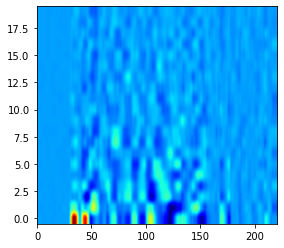

In [12]:
F = extractMFCCdelta('queries/command1/A1_normal.mp3') 
print(F.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.imshow(F, interpolation='nearest')
ax.imshow(F[:,:], cmap = 'jet', origin = 'lower')
ax.set_aspect(10)


In [13]:
ipd.Audio('training/command1/A1_normal.mp3')

# Construct Data Base

For analysis:
<br />-construct a new reference template database for each person
<br />-when using person X for reference templates, remove person X's normal commands from db_queries

In [18]:
def constructDB(indir):
    '''
    Constructs a database containing the delta MFCC feature matrices for reference templates.
    
    Arguments:
    indir -- directory containing the mp3 files to store in the database
    
    Returns:
    db -- a dictionary where the key is the name of the piece and the value is its chroma feature matrix
    '''
    db = {}
    
    commands = ["command1", "command2", "command3", "command4", "command5"]     
    
    for c in commands:
        file_list = []
        file_list += glob.glob(os.path.join(indir+"/"+c, "*.mp3"))
        
        value_list = []
        for filename in file_list:
            print(filename)
            value_list = value_list + [extractMFCCdelta(filename)]  # store delta delta FEATURES
               
        db[c] = value_list

    return db

Construct reference templates using one person's commands audio files. Note: This database should always be of length 5 for the 5 different commands

In [19]:
db_ref = constructDB("reference_templates")

reference_templates/command1\F1_normal.mp3
reference_templates/command2\F2_normal.mp3


C:\Users\lauren\anaconda3\envs\E190_LETS_GO\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


reference_templates/command3\F3_normal.mp3
reference_templates/command4\F4_normal.mp3
reference_templates/command5\F5_normal.mp3


In [20]:
db_queries = constructDB("queries")  # split folders based on command?

queries/command1\A1_fast.mp3
queries/command1\A1_high.mp3
queries/command1\A1_low.mp3
queries/command1\A1_normal.mp3
queries/command1\A1_slow.mp3
queries/command1\B1_fast.mp3
queries/command1\B1_high.mp3
queries/command1\B1_low.mp3
queries/command1\B1_normal.mp3
queries/command1\B1_slow.mp3
queries/command1\C1_fast.mp3
queries/command1\C1_high.mp3
queries/command1\C1_low.mp3
queries/command1\C1_normal.mp3
queries/command1\C1_slow.mp3
queries/command1\D1_fast.mp3
queries/command1\D1_high.mp3
queries/command1\D1_low.mp3
queries/command1\D1_normal.mp3
queries/command1\D1_slow.mp3
queries/command1\F1_fast.mp3
queries/command1\F1_high.mp3
queries/command1\F1_low.mp3
queries/command1\F1_normal.mp3
queries/command1\F1_slow.mp3
queries/command1\G1_fast.mp3
queries/command1\G1_high.mp3
queries/command1\G1_low.mp3
queries/command1\G1_normal.mp3
queries/command1\G1_slow.mp3
queries/command1\H1_fast.mp3
queries/command1\H1_high.mp3
queries/command1\H1_low.mp3
queries/command1\H1_normal.mp3
queries

### How to save database

Call the constructDB function and save the database to file using `pickle.dump` for later use.  Note that this may take about a minute to run.

In [ ]:
# with open('db.pkl', 'wb') as f: 
#     pickle.dump(db_,f)

In [38]:
# with open('db.pkl', 'rb') as f:
#     db = pickle.load(f)

# Compute Cost, Find Optimal Path Score

1. Compute cost matrix between reference and query

In [24]:
def computeCostMatrix_cosdist(Fquery,Fref):
    '''
    Computes the cosine distance cost matrix.
    
    Arguments:
    Fquery -- the query MFCC delta feature matrix of dimension (12, # query frames)
    
    Fref -- the reference MFCC delta feature feature matrix, of dimension (12, # reference frames)
    
    Returns:
    C -- cost matrix whose (i,j)th element specifies the cosine distance between the i-th query frame
         and the j-th reference frame
    '''
    C = 1 - np.dot(np.transpose(Fquery), Fref)

    mag =np.dot(np.abs(np.transpose(Fquery)), np.abs(Fref))
    
    cost = 1 - np.divide(np.dot(np.transpose(Fquery), Fref), mag)

    return cost

In [25]:
def backtrace(D, B, steps):
    '''
    Backtraces through the cumulative cost matrix D.
    
    Arguments:
    D -- cumulative cost matrix
    B -- backtrace matrix
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)   list of lists
    
    Returns:
    path -- a python list of (row, col) coordinates for the optimal path.
    '''
    path = []

    height, width = D.shape
    dmin = D[height-1,:]
    mini = np.unravel_index(np.argmin(dmin, axis=None), dmin.shape)
    col = mini[0]
    row = height-1
    
    while(row>=0): 
        path.append([row,col])
        stepi = B[row,col]
        row = row - steps[stepi][0]
        col = col - steps[stepi][1]
        if col <0:
            col = 0
      
    return path

### Subsequence DTW 

In [26]:
def subsequenceDTW(C, steps, weights):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    D = np.zeros(C.shape)  # D is cumulative, C is cost of each
    B = np.zeros(C.shape, dtype=np.int8)

    # CONSTRUCTING D MATRIX
    D[0,:] = C[0,:] 
    Dmin = np.zeros(steps.shape[0])
    for r in np.arange(1,D.shape[0]): #looping through row
        for c in np.arange(D.shape[1]): #:y(steps.shape[0])
            for i in np.arange(steps.shape[0]):
                if r-steps[i,0] <0  or c-steps[i,1]< 0:
                    Dmin[i] = np.inf
                else:
                    Dmin[i] = (D[r-steps[i,0],c-steps[i,1]] + C[r,c])*weights[i]
                    
            # Find the minimum to find our Dval
            D[r,c] = min(Dmin)
                    
            B[r,c] = np.argmin(Dmin)
    
    #call the backtrace function to determine the optimal path
    path = backtrace(D, B, steps)
    path.reverse()
    optcost = min(D[D.shape[0]-1,:])
    
    path = np.array(path)
    
    return optcost, path

# Compute accuracy for 1 command

In [27]:
def command_accuracy(indir, command_number, db_ref, steps, weights):
    """
    Arguments:
        indir = the directory to all of the query commands. for example: 'training/command1'

        command_number = classify which command the query should be

        db_ref = the database of reference templates

        steps = a numpy matrix specifying the allowable transitions.  It should be of
                dimension (L, 2), where each row specifies (row step, col step)

        weights = a vector of size L specifying the multiplicative weights associated 
                  with each of the allowable transitions
    Returns:
        accuracy = the ratio that query was correctly matched with correct command from reference database

    """
    # store all query files
    file_list = []
    file_list = glob.glob(os.path.join(indir+"/", "*.mp3"))  # get all mp3 files in indir
    
    correct = 0
    total = 0

    for queryfile in file_list:
        MFCC_delta_query = extractMFCCdelta(queryfile)
        
        # compares query_file with 5 reference templates in db_ref
        cost_list = []
        
        
        for command in db_ref:
            for i in range(len(db_ref[command])):
                MFCC_ref = db_ref[command][i]
                C = computeCostMatrix_cosdist(MFCC_delta_query,MFCC_ref) # cost matrix

                D, wp = lb.sequence.dtw(C=C, step_sizes_sigma=steps, weights_mul=weights, metric = 'cosine', subseq=True)
                path = wp
                cost = np.min(D[-1,:])
                cost_list += [cost]
        
        
        if np.argmin(cost_list)+1 == command_number:
            correct +=1
        total+=1
    
    accuracy = correct/total
                  
    return accuracy

In [32]:
def compute_accuracy_for_5_commands(steps, weights, db_ref):
    """
    parameter examples:
    
    steps = np.array([1,0,0,1,1,1]).reshape((3,2))
    weights = [1,1,1]
    
    """
    indir_list = ["queries/command1", "queries/command2", "queries/command3", "queries/command4", "queries/command5"]
    command_number_list = [1,2,3,4,5]
    
    accuracy_list = []

    for i in range(len(command_number_list)):
        print("command ", i+1)
        command_number = command_number_list[i]
        indir = indir_list[i]
        accuracy = command_accuracy(indir=indir, command_number = command_number, db_ref = db_ref, steps = steps, weights = weights)
        
        accuracy_list += [accuracy]
        print(accuracy)
    
    return accuracy_list

In [35]:
def total_accuracy(accuracy_list):
    val = np.mean(accuracy_list)
    print("total accuracy: ", val)
    return val

# Example: How to check accuracies given reference template database. Note: only change db_ref for analysis on reference templates

In [37]:
# defining parameters, NOTE: steps and weights values were chosen by trial and error to obtain highest accuracy possible
steps = np.array([1,0,0,1,2,2]).reshape((3,2))
weights = [.4,.4,1]
db_ref = db_ref  # THIS WILL CHANGE EVERYTIME WE CHOOSE DIFFERENT PERSON FOR TEMPLATE

accuracy_list = compute_accuracy_for_5_commands(steps, weights, db_ref)
total_accuracy(accuracy_list)

command  1
0.525
command  2
0.5
command  3
0.5428571428571428
command  4
1.0
command  5
0.95
total accuracy:  0.7035714285714285


0.7035714285714285

# How to plot cost matrix

Shows how 1 query compares to reference template

In [ ]:
queryfile = "training/command3/A3_normal.mp3"
MFCC_delta_query = extractMFCCdelta(queryfile) 


for command in db_ref:
    for i in range(len(db_ref[command])):
        MFCC_ref = db_ref[command][i]
        C = computeCostMatrix_cosdist(MFCC_delta_query,MFCC_ref) # cost matrix
    
        D, wp = lb.sequence.dtw(C=C, step_sizes_sigma=steps, weights_mul=weights, metric = 'cosine', subseq=True)
        path = wp
        cost = np.min(D[-1,:])
        print("cost", cost)
        
          
        # PLOT COST MATRIX
        plt.figure(figsize=(20,6))
        plt.imshow(C, cmap='jet',origin='lower')
        y, x = zip(*wp) 
        plt.scatter(x,y) # scatter is able to overlay plots 🙂 

        plt.title("Cost Matrix with Optimal Path Overlayed")
        plt.xlabel("Reference Frame")
        plt.ylabel("Query Frame")
        plt.show()